<h2> Nauczanie maszynowe/Ćwiczenia3

# Maszyna wektorów nośnych (SVM)

In [1]:
from sklearn import datasets
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<h4> Liniowe SVM

Cel: Rozdzielenie danych za pomocą hiperpłaszczyny (w podstawowej wersji na 2 grupy; można uogólnić)


- Chcemy zmaksymalizować marignes równy $\frac{2}{||w||}$ 

- W podstawowej wersji zadanie to sprowadza się do minimalizacji $J(w)=\frac{1}{2}||w||^2$ przy warunkach $y_i(w^Tx_i+w_0)\geq 1$

- W praktyce idealna separowalność liniowa nie zachodzi, musimy zatem dopuścić pewne niezgodnośći, wprowadzamy dodatkowe zmienne do rozwiązywanego problemu ($\eta_i$), który w tym momencie sprowadza się do minimalizacji $J(w)=\frac{1}{2}||w||^2+C\sum_{i}\eta_i$ przy warunkach $y_i(w^Tx_i+w_0)\geq 1 - \eta_i$

Uwaga:
- $\eta_i \in (0,1)$ to próbka jest po dobrej stronie ale wyszła poza margines
- $\eta_i>1$, to próbka jest po złej stronie

To nam narzuca interpretację $C$.Jaka ona jest?

In [2]:
#rozwazam dane iris
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

#standaryzacja
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1., random_state=0)
svm.fit(X_train_std, y_train);

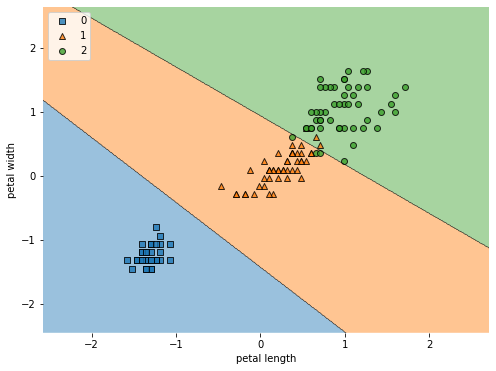

In [4]:
plt.figure(figsize=(8, 6))

X_all = np.vstack( (X_train_std, X_test_std) )
y_all = np.hstack( (y_train, y_test) )
plot_decision_regions(X=X_all, y=y_all, clf=svm)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()

In [5]:
svm.score(X_test_std, y_test) #dokladnosc

0.9777777777777777

<h4> Zadanie1: Rozważ poniższe dane. Zastosuj algorytm SVM dla różnych parametrów C: 0.01, 10. Zwizualizuj i skomentuj w kilku zdaniach otrzymane wyniki.

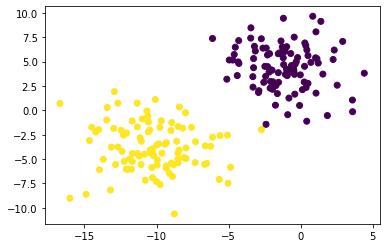

In [6]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, random_state=1, n_features=2, centers = 2, cluster_std = 2.4)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

<h4> Kernel

Dane często nie są separowalne liniowo, jednak klasyfiaktory liniowe dalej mogą działać! Wystarczy zastosować odpowiednie przekształcenie danych (kernel)

Przykładowa funkcja, jedna z najczęsciej używanych to RBF, zdefiniowana jest jako $K(x,y) = -\exp(-\frac{1}{2\sigma^2} ||x-y||^2)= \exp(-\gamma ||x-y||^2)$

Inne: wielomianowy, sigmoidalny,...

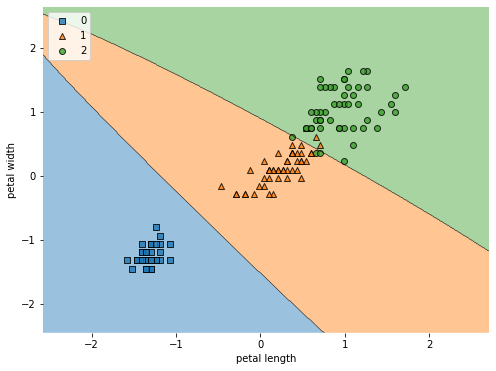

In [7]:
svm = SVC(kernel='rbf', C=1., gamma=0.1, random_state=0)
svm.fit(X_train_std, y_train)

plt.figure(figsize=(8, 6))
plot_decision_regions( X=X_all , y=y_all , clf=svm)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()

<h4> Zadanie2: Przetestować inne wartości $\gamma$ (np. 10, 50) dla danych wyżej. Skomentować wyniki w konkteście definicji parametru $\gamma$.

<h3> Rozpoznawanie twarzy

In [8]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 60)
print(faces.target_names) #jakie osoby tam są?
print()
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']

(1348, 62, 47)


Każde zdjęcie jest wymiaru $62 \times 47$, czyli $2914$ pikseli. To dużo... Zastosujemy PCA (o PCA będzie więcej w przyszłości, na tę chwile wystarczy widzieć, że efektem będzie zredukowana liczba zmiennych)

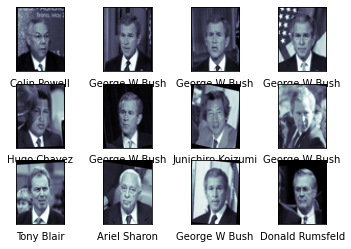

In [9]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = "bone")
    axi.set(xticks = [], yticks = [],
           xlabel = faces.target_names[faces.target[i]])

In [10]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = RandomizedPCA(n_components = 150, whiten = True, random_state = 42)
svc = SVC(kernel = "rbf", random_state = 0)
model = Pipeline([('pca', pca), ('svc',svc)])

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.3, random_state=42)

param_grid = {"svc__C": [1, 5, 10, 50],
              "svc__gamma": [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
grid = grid.fit(X_train, y_train)

In [11]:
grid.best_params_

{'svc__C': 5, 'svc__gamma': 0.005}

In [12]:
grid.score(X_test, y_test)

0.7654320987654321

In [13]:
m = grid.best_estimator_
yfit = m.predict(X_test)

In [14]:
m

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC(C=5, gamma=0.005, random_state=0))])

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit, target_names = faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.71      0.77        17
     Colin Powell       0.85      0.79      0.81        84
  Donald Rumsfeld       0.69      0.56      0.62        36
    George W Bush       0.72      0.97      0.82       146
Gerhard Schroeder       0.72      0.64      0.68        28
      Hugo Chavez       0.80      0.30      0.43        27
Junichiro Koizumi       1.00      0.81      0.90        16
       Tony Blair       0.80      0.63      0.70        51

         accuracy                           0.77       405
        macro avg       0.80      0.67      0.72       405
     weighted avg       0.78      0.77      0.75       405



<h4> Zadanie3: Otwórz plik "spam_ham.txt". Zawiera on wiadomości spam/ham. Każda linijka zawiera jedną wiadomość.
    
- Czy dane są zbalansowane? Dlaczego?
- Podziel dane na zbiór treningowy i testowy (8:2)
- Zastostuj transformację TF-IDF celem przekształcenia zdań na wektory liczb
- Zbuduj model w oparciu o regresję logistyczną oraz SVM
- Porównaj czułość/precyzję/f1-score dla obu klas w zbudowanych modelach. Jak modele radzą sobię z niezbalansowaniem?
- Zbalansuj dane i zbuduj modele jeszcze raz. Porównaj wyniki

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Uzupełnienie

<h3> Pipeliny + Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'clf__C':param_range, 'clf__kernel':['linear']},
              {'clf__C':param_range, 'clf__kernel':['rbf'], 'clf__gamma':param_range}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [17]:
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
gs = gs.fit(X_train, y_train) #uczymy na zbiorze treninogwym, mozna by jeszcze wydzielic zbior walidacyjny (jakby bylo wiecej danych)

In [18]:
print(gs.best_score_, gs.best_params_, gs.score(X_test, y_test))

0.9527272727272728 {'clf__C': 0.1, 'clf__kernel': 'linear'} 0.9555555555555556


<h3> Krosswalidacja

In [19]:
"""
###K-fold --> dane są dzielone na k podzbiorow, kazdy z nich bierze sie jako zbior testowy (a pozostale treningowe),
           efektem jest k wynikow ktore pozniej się usrednia
           
from sklearn.model_selection import KFold, cross_val_score
k_folds = KFold(n_splits = 5)
scores = cross_val_score(clf, X, y, cv = k_folds)  #clf = metoda, np DecisionTreeClassifier()



###Stratified K-Fold --> dzielimy na zbior uczący i testowy tak zeby byly zachowane proporcje pomiedzy klasami decyzyjnymi
                         (zwlaszcza wazne gdy są duze dysproporcje w danych)

from sklearn.model_selection import StratifiedKFold, cross_val_score
sk_folds = StratifiedKFold(n_splits = 5)
scores = cross_val_score(clf, X, y, cv = sk_folds)



###Leave-One-Out (LOO) --> jak K-fold, tyle ze 1 podzbior to jedna dana, liczba krosswalidacji = liczba obserwacji,
                        często dla malych danych

from sklearn.model_selection import LeaveOneOut, cross_val_score
loo = LeaveOneOut()
scores = cross_val_score(clf, X, y, cv = loo)



###Leave-P-Out (LPO)  --> to co wyzej, z tym ze mozemy dobrac parametr p na zbiorze walidacyjnym

from sklearn.model_selection import LeavePOut, cross_val_score
lpo = LeavePOut(p=2)
scores = cross_val_score(clf, X, y, cv = lpo)




###Shuffle Split --> pomija pewien procent danych

from sklearn.model_selection import ShuffleSplit, cross_val_score
ss = ShuffleSplit(train_size=0.6, test_size=0.3, n_splits = 5)
scores = cross_val_score(clf, X, y, cv = ss)
"""

'\n###K-fold --> dane są dzielone na k podzbiorow, kazdy z nich bierze sie jako zbior testowy (a pozostale treningowe),\n           efektem jest k wynikow ktore pozniej się usrednia\n           \nfrom sklearn.model_selection import KFold, cross_val_score\nk_folds = KFold(n_splits = 5)\nscores = cross_val_score(clf, X, y, cv = k_folds)  #clf = metoda, np DecisionTreeClassifier()\n\n\n\n###Stratified K-Fold --> dzielimy na zbior uczący i testowy tak zeby byly zachowane proporcje pomiedzy klasami decyzyjnymi\n                         (zwlaszcza wazne gdy są duze dysproporcje w danych)\n\nfrom sklearn.model_selection import StratifiedKFold, cross_val_score\nsk_folds = StratifiedKFold(n_splits = 5)\nscores = cross_val_score(clf, X, y, cv = sk_folds)\n\n\n\n###Leave-One-Out (LOO) --> jak K-fold, tyle ze 1 podzbior to jedna dana, liczba krosswalidacji = liczba obserwacji,\n                        często dla malych danych\n\nfrom sklearn.model_selection import LeaveOneOut, cross_val_score\nloo

<h2> Optymalizatory

Jak widzieliśmy na poprzednich i tych zajęciach, różne metody często wykorzystują różne funkcje kosztu. W tym podrozdziale zaimplementujemy w pytorch różne metody optymalizacji, zaczynając już od znanej metody spadku gradientu. 

In [20]:
import torch
from utils import visualize_optimizer
from checker import test_optimizer

Definiujemy klasę rodzic dla kolejnych metod.

In [21]:
from typing import List

class Optimizer:
    """Klasa bazowa dla optymalizatorów"""
    
    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """w self.params będą aktualizacje wag"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch akumuluje gradient, więc go zerujemy po kazdej aktualizacji"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

### Metoda spadku gradientu

<font size="+2"> $$\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)$$  </font><br>

In [22]:
class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
    
    @torch.no_grad()
    def step(self):
        for param in self.params:
            param -= self.learning_rate * param.grad

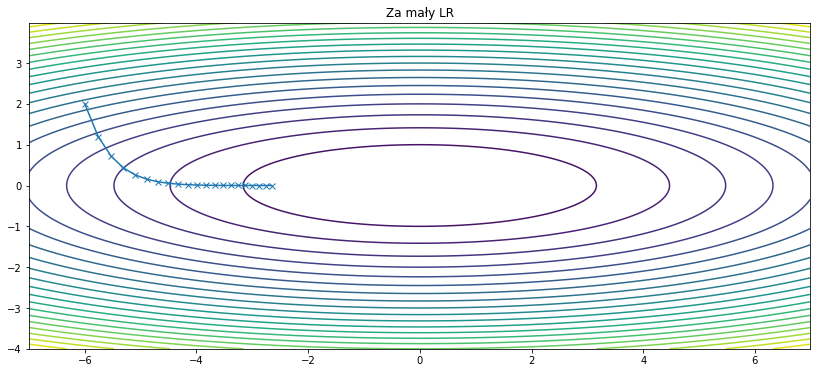

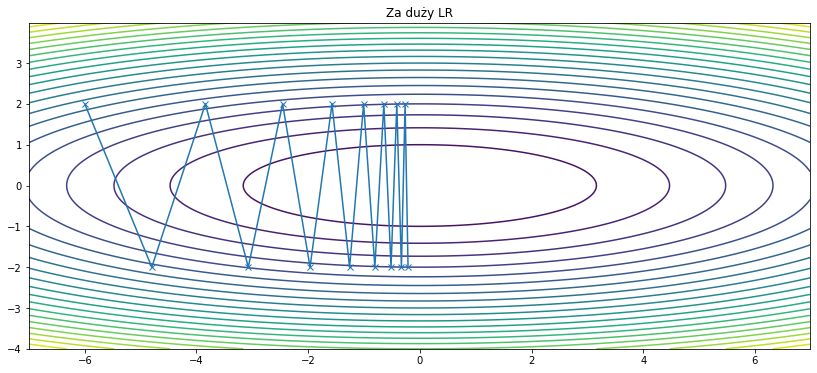

In [23]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Za mały LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Za duży LR')

### Momentum
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>

#### Uwagi
* $\Delta_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.

<h4> Zadanie4: Uzupełnij definicję poniżej klasy.

In [24]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.deltas = []
        
        for param in self.params:
            self.deltas.append(torch.zeros_like(param))
              
    @torch.no_grad()
    def step(self):
        ???

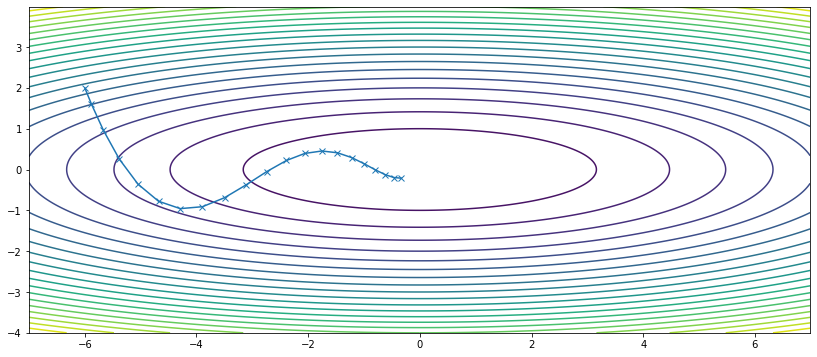

In [25]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

### Adagrad  
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

W każdym korku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie5: Uzupełnij definicję poniżej klasy.

In [26]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        ???
    
    @torch.no_grad()
    def step(self):
        ???

In [27]:
test_optimizer(Adagrad)

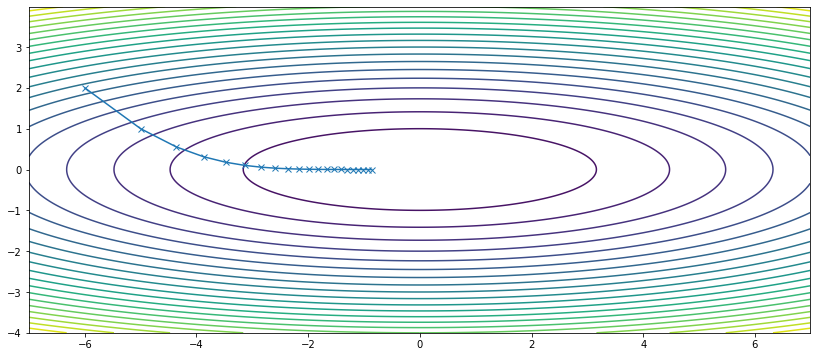

In [28]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

### RMSProp  
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie6: Uzupełnij definicję poniżej klasy.

In [29]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        ???
        
    @torch.no_grad()
    def step(self):
        ???

In [30]:
test_optimizer(RMSProp)

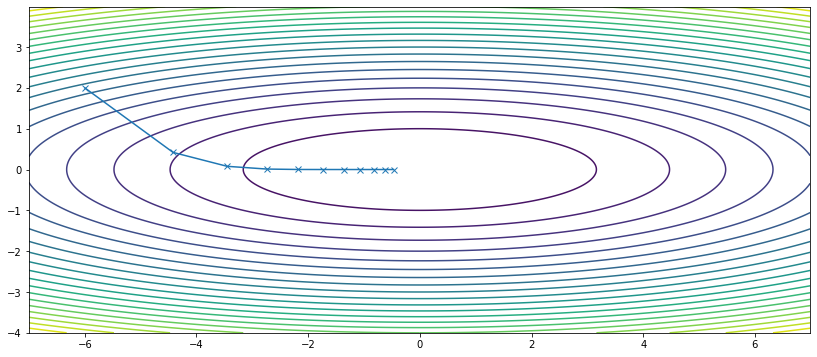

In [31]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

### Adadelta  
Hiperparametry:
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 oraz rozpoczęcia uczenia (typowo $10^{-8}$ do $10^{-2}$)

Eliminujemy stałą uczenia $\eta$ i sprawiamy, że "prędkość" poprawek jest podobna do faktycznych poprawek uzależniając krok uczenia od średniej kroczącej poprzednich poprawek.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \Delta_{t+1} = \frac{\sqrt{D_{t} + \epsilon}}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \Delta_{t+1} $$ </font>

<font size="+2"> $$ D_{t+1} = \gamma D_{t} + (1 - \gamma) \Delta_{t+1}^2 $$ </font>

#### Uwagi:
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $D_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie7: Uzupełnij definicję poniżej klasy.

In [32]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon

        ???
        
    @torch.no_grad()
    def step(self):
        ???

In [33]:
test_optimizer(Adadelta)

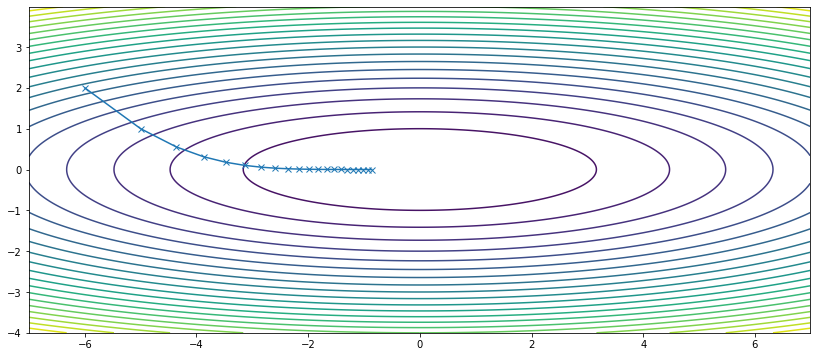

In [34]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)

### Adam 

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


<h4> Zadanie8: Uzupełnij definicję poniżej klasy.

In [35]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        ???
        
    @torch.no_grad()
    def step(self,):
        
        ???

In [36]:
test_optimizer(Adam)

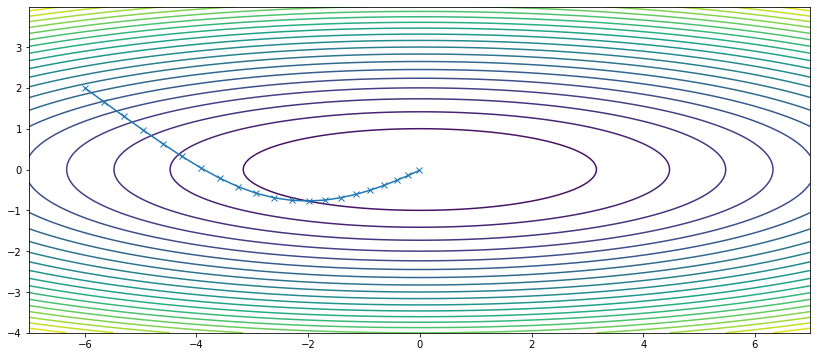

In [37]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)

<h4> Uzupełnienie

In [7]:
#Operacje na tensorach
x = torch.tensor([4, 9])
print(torch.sqrt(x)) #pierwiastki
print()
print(torch.pow(x, 2)) #potęgi

tensor([2., 3.])

tensor([16, 81])
